#  Detección de DGA

Fuente: https://github.com/osunjio/applied_data_science_sidi/blob/78e6da047845d071667bb887e28a5c120c8e6a12/answers/Worksheet%205.2%20-%20DGA%20Detection%20using%20Supervised%20Learning%20-%20Answers.ipynb

Para este modelo se utilizan las siguientes librerías:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* YellowBrick (http://www.scikit-yb.org/en/latest/)
* Seaborn (https://seaborn.pydata.org)

In [1]:
#Importar las librerías

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

## Parte 1: Ingeniería de características

In [2]:
## Cargar el dataset proporcionado
df = pd.read_csv('dga_data_small.csv')
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)

#Ejemplos de dominios DGA
df[df.isDGA == 'dga'].sample(5) 

(2000, 2)


,isDGA,domain
251,dga,ba671d1be631a3dcf761bed552cfef3b
230,dga,1chob2liqu89d1sur5mdmqy6e5
43,dga,1gqok7710nnz5u24m2rlwzcbal
703,dga,mnvkffeavcydpnwklrteimbc
509,dga,ibnmdqpbyccumzrgskbeql


In [3]:
#Ejemplos de dominios legitimos
df[df.isDGA == 'legit'].sample(5)

,isDGA,domain
1562,legit,pluginbeast
1035,legit,postdirect
1657,legit,eresourcesonline
1307,legit,popcornpartner
1102,legit,800disk


**Lista de características a derivar (basado en artículos académicos)**:

1. Longitud del dominio
2. Cantidad de digitos
3. Entropia (Shanon y relativa)
4. Proporcion entre vocales y consonantes
5. Posicion (indice) del primer digito

In [5]:
from six.moves import cPickle as pickle
with open('d_common_en_words' + '.pickle', 'rb') as f:
        d = pickle.load(f)

def entropyShanon (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [4]:
#Copiado de https://redcanary.com/blog/threat-hunting-entropy/
def relative_entropy(data):
    #Calculate the relative entropy (Kullback-Leibler divergence) between data and expected values.
    entropy = 0.0
    length = len(data) * 1.0

    if length > 0:
        cnt = Counter(data)
            
        # These probability numbers were calculated from the Alexa Top
        # 1 million domains as of September 15th, 2017. TLDs and instances
        # of 'www' were removed so 'www.google.com' would be treated as
        # 'google' and 'images.google.com' would be 'images.google'.
        probabilities = {
            '-': 0.013342298553905901,
            '_': 9.04562613824129e-06,
            '0': 0.0024875471880163543,
            '1': 0.004884638114650296,
            '2': 0.004373560237839663,
            '3': 0.0021136613076357144,
            '4': 0.001625197496170685,
            '5': 0.0013070929769758662,
            '6': 0.0014880054997406921,
            '7': 0.001471421851820583,
            '8': 0.0012663876593537805,
            '9': 0.0010327089841158806,
            'a': 0.07333590631143488,
            'b': 0.04293204925644953,
            'c': 0.027385633133525503,
            'd': 0.02769469202658208,
            'e': 0.07086192756262588,
            'f': 0.01249653250998034,
            'g': 0.038516276096631406,
            'h': 0.024017645001386995,
            'i': 0.060447396668797414,
            'j': 0.007082725266242929,
            'k': 0.01659570875496002,
            'l': 0.05815885325582237,
            'm': 0.033884915513851865,
            'n': 0.04753175014774523,
            'o': 0.09413783122067709,
            'p': 0.042555148167356144,
            'q': 0.0017231917793349655,
            'r': 0.06460084667060655,
            's': 0.07214640647425614,
            't': 0.06447722311338391,
            'u': 0.034792493336388744,
            'v': 0.011637198026847418,
            'w': 0.013318176884203925,
            'x': 0.003170491961453572,
            'y': 0.016381628936354975,
            'z': 0.004715786426736459
        }
            
        for char, count in cnt.items():
            observed = count / length
            expected = probabilities[char]
            entropy += observed * np.log2(observed / expected)
            
        return entropy

In [6]:
df['ngrams'] = df['domain'].apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1), 
                                                                ngram_feature(x, d, 2), 
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df.sample(10)
df['entropy'] = df['domain'].apply(entropyShanon)
df['entropyRelative'] = df['domain'].apply(relative_entropy)
df['vowel-cons'] = df['domain'].apply(vowel_consonant_ratio)
df['firstDigitIndex'] = df['domain'].apply(firstDigitIndex)
# Calcular las características faltantes length y digits

df['length'] = df['domain'].str.len()
df['digits'] = df['domain'].str.count('[0-9]')


# Codifique para la columna isDGA: dga con el valor 1, y legit con el valor 0

df['isDGA'] = df['isDGA'].replace(to_replace = 'dga', value=1)
df['isDGA'] = df['isDGA'].replace(to_replace = 'legit', value=0)


print(df['isDGA'].value_counts())
df.sample(n=5).head()


1    1000
0    1000
Name: isDGA, dtype: int64


,isDGA,domain,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits
1459,0,juetuzhi,1014.736111,2.750000,2.470222,1.00,0,8,0
479,1,wyaecynekmopcef,1182.164225,3.323231,1.555296,0.50,0,15,0
1880,0,etvizler,1546.783730,2.750000,1.981312,0.60,0,8,0
1030,0,avathemes,1624.449735,2.725481,1.675902,0.80,0,9,0
722,1,cuksooiaxfdisk,1113.028694,3.235926,1.616143,0.75,0,14,0


In [7]:
df_final = df
df_final = df_final.drop(['domain'], axis=1)
df_final.to_csv('dga_features.csv', index=False)
df_final.head()

,isDGA,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits
0,1,744.670940,3.546594,1.952051,0.083333,0,13,0
1,1,715.217265,4.132944,2.158377,0.333333,1,26,10
2,1,1918.797619,2.500000,1.633473,0.333333,0,8,0
3,1,682.269402,4.180833,1.584979,0.357143,1,26,7
4,1,544.178140,3.834963,3.060879,0.666667,2,24,9


## Visualización de la data

In [8]:
feature_names = ['length','digits','entropy','entropyRelative','vowel-cons','firstDigitIndex', 'ngrams']
features = df_final[feature_names]
target = df_final['isDGA']

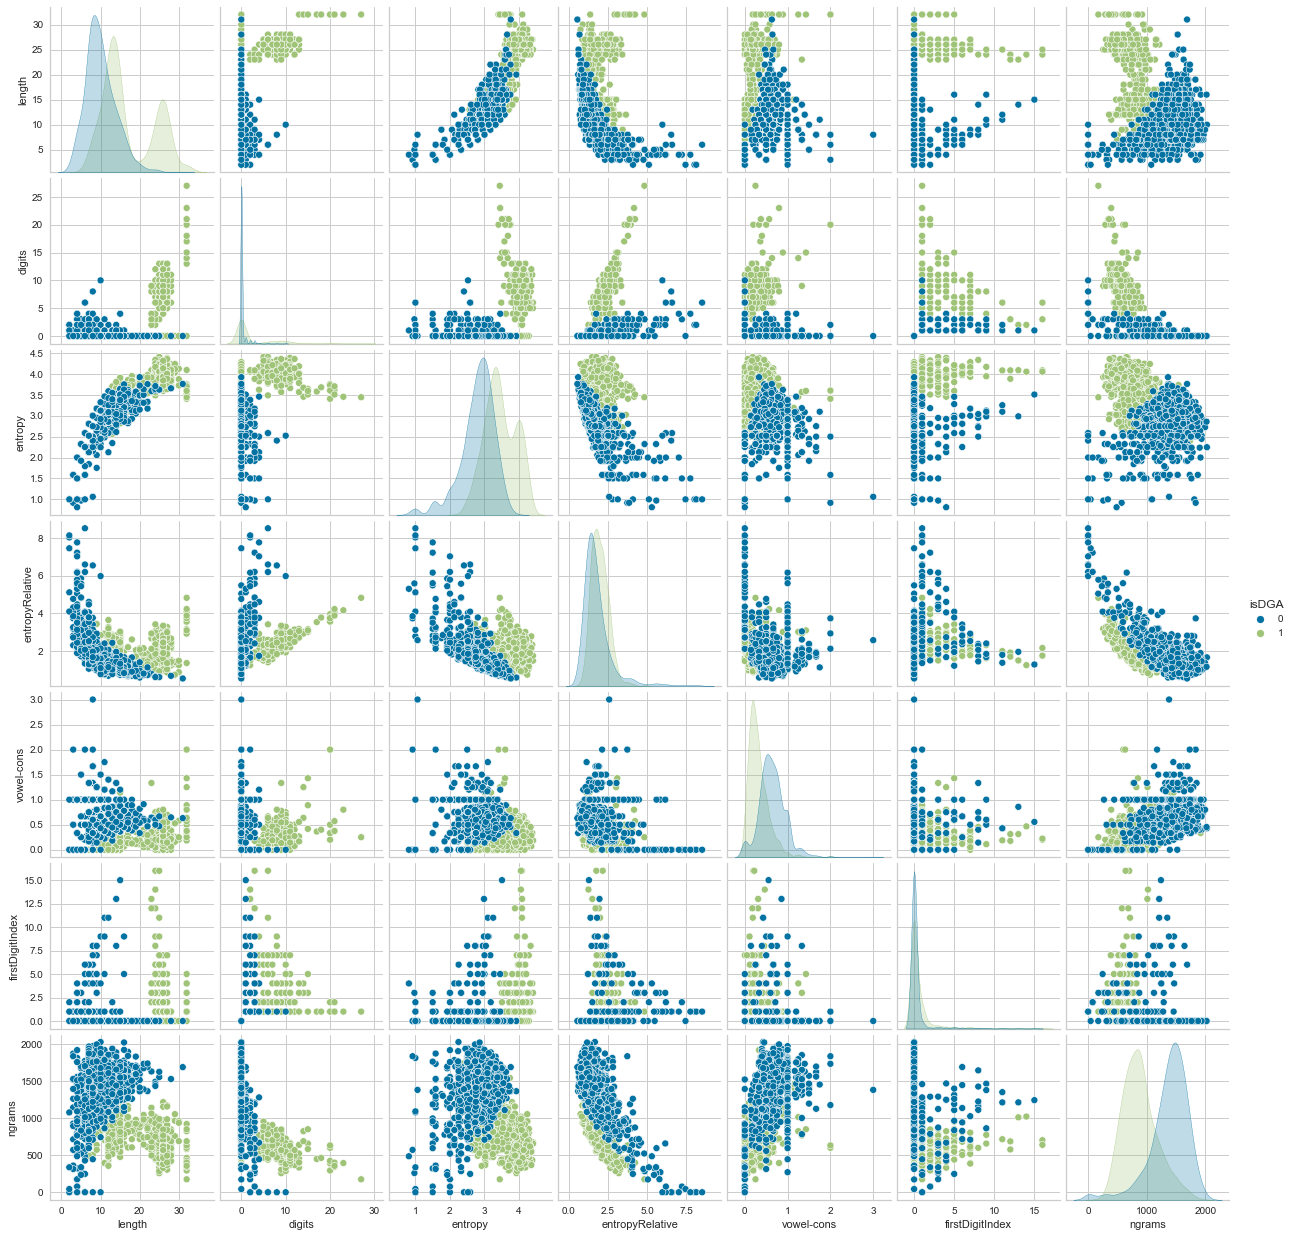

In [9]:
sns.pairplot(df_final, hue='isDGA', vars=feature_names)

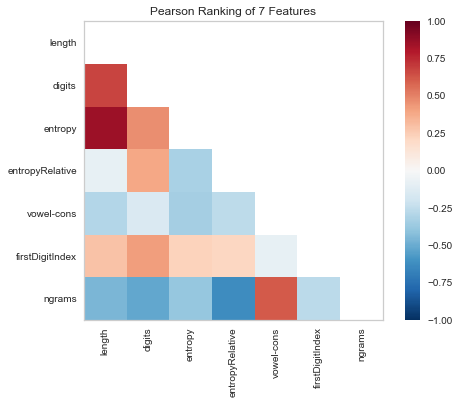

<AxesSubplot:title={'center':'Pearson Ranking of 7 Features'}>

In [10]:
visualizer = Rank2D(algorithm='pearson',features=feature_names)
visualizer.fit_transform( features )
visualizer.poof()

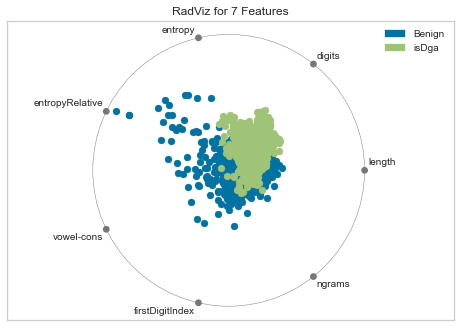

<AxesSubplot:title={'center':'RadViz for 7 Features'}>

In [11]:
features = df_final[feature_names].values
target = df_final['isDGA'].values

radvizualizer = RadViz(classes=['Benign','isDga'], features=feature_names)
radvizualizer.fit_transform( features, target)
radvizualizer.poof()

## Parte 2: Implementación del modelo

### Paso 1: Prepare la matriz de características y el vector Target

- En estadistica, la matriz de características es normalmente conocida como ```X```
- Target es un vector que contiene las etiqueras para cada URL (también conocido como  *y* en estadistica)
- En sklearn X y el Objetivo pueden ser ambos pandas DataFrame/Series o numpy array/vector (no pueden ser listas!)

In [12]:
target = df_final['isDGA']
feature_matrix = df_final.drop(['isDGA'], axis=1)
print('Final features', feature_matrix.columns)

feature_matrix.head()

Final features Index(['ngrams', 'entropy', 'entropyRelative', 'vowel-cons', 'firstDigitIndex',
       'length', 'digits'],
      dtype='object')


,ngrams,entropy,entropyRelative,vowel-cons,firstDigitIndex,length,digits
0,744.670940,3.546594,1.952051,0.083333,0,13,0
1,715.217265,4.132944,2.158377,0.333333,1,26,10
2,1918.797619,2.500000,1.633473,0.333333,0,8,0
3,682.269402,4.180833,1.584979,0.357143,1,26,7
4,544.178140,3.834963,3.060879,0.666667,2,24,9


### Paso 2: Separación de datos

- Divida el dataset en datos de entrenamiento (75%) y prueba (25%), en las variables feature_matrix_train, feature_matrix_test, target_train, target_test

In [13]:
feature_matrix_train, feature_matrix_test, target_train, target_test = model_selection.train_test_split(feature_matrix, target, test_size=0.25, random_state=33)

In [14]:
feature_matrix_train.count()

ngrams             1500
entropy            1500
entropyRelative    1500
vowel-cons         1500
firstDigitIndex    1500
length             1500
digits             1500
dtype: int64

In [15]:
feature_matrix_test.count()

ngrams             500
entropy            500
entropyRelative    500
vowel-cons         500
firstDigitIndex    500
length             500
digits             500
dtype: int64

In [16]:
target_train.head()

1179    0
1529    0
1125    0
1739    0
1303    0
Name: isDGA, dtype: int64

In [17]:
target_train.value_counts()

1    756
0    744
Name: isDGA, dtype: int64

### Paso 3: Entrenamiento del modelo

- Use el modelo de árbol de decisión de sklearn [tree.DecisionTreeClassfier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), y cree un modelo con los parámetros estandar , luego entrenelo usando la función ```.fit()``` con la data ```X_train``` y ```target_train```.

In [18]:
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(feature_matrix_train, target_train)

# Extract a row from the test data
test_feature = feature_matrix_test[192:193]
test_target = target_test[192:193]

# Make the prediction
pred = clf.predict(test_feature)
print('Predicted class:', pred)
print('Accurate prediction?', pred[0] == test_target)

Predicted class: [0]
Accurate prediction? 1500    True
Name: isDGA, dtype: bool


In [19]:
pred[0] == test_target

1500    True
Name: isDGA, dtype: bool

### Paso 4: Predicciones

- Para poder hacer predicciones con el modelo, se deben derivar las características de las URLs de prueba

In [20]:
def is_dga(domain, clf, d):
    # Parámetros: dominio y el modelo entrenado clf
    # Retorna una predicción 
    
    domain_features = np.empty([1,7])
    # orden de las características ['length', 'digits', 'entropy', 'vowel-cons', firstDigitIndex]
    domain_features[0,0] = len(domain)
    pattern = re.compile('([0-9])')
    domain_features[0,1] = len(re.findall(pattern, domain))
    domain_features[0,2] = entropyShanon(domain)
    domain_features[0,3] = relative_entropy(domain)
    domain_features[0,4] = vowel_consonant_ratio(domain)
    domain_features[0,5] = firstDigitIndex(domain)
    domain_features[0,6] = average_ngram_feature([ngram_feature(domain, d, 1), 
                                                  ngram_feature(domain, d, 2), 
                                                  ngram_feature(domain, d, 3)])
    pred = clf.predict(domain_features)
    return pred[0]

Utilice la función is_dga para realizar predicciones sobre los siguientes dominios de prueba:

- microsoft
- google
- 1vxznov16031kjxneqjk1rtofi6

In [21]:
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('microsoft'), is_dga('microsoft', clf,d))  
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('google'), is_dga('google', clf,d)) 
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('1vxznov16031kjxneqjk1rtofi6'), is_dga('1vxznov16031kjxneqjk1rtofi6', clf,d)) 


Predictions of domain microsoft is [0 means legit and 1 dga]:  0
Predictions of domain google is [0 means legit and 1 dga]:  0
Predictions of domain 1vxznov16031kjxneqjk1rtofi6 is [0 means legit and 1 dga]:  1


/Users/jyass/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/jyass/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/jyass/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Paso 5: Validación

- Cálculo de la matriz de validación

In [22]:
target_pred = clf.predict(feature_matrix_test)
print(metrics.accuracy_score(target_test, target_pred))
print('Confusion Matrix\n', metrics.confusion_matrix(target_test, target_pred))

0.866
Confusion Matrix
 [[216  40]
 [ 27 217]]


Etiquete de forma apropiada la matriz, y explique el valor de:

- Verdaderos positivos
- Verdaderos negativos
- Falsos positivos
- Falsos negativos

In [23]:
print(metrics.classification_report(target_test, target_pred, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.89      0.84      0.87       256
         dga       0.84      0.89      0.87       244

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [25]:
#Fuente: https://www.w3schools.com/python/python_ml_auc_roc.asp
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 

model 2 AUC score: 0.866547131147541


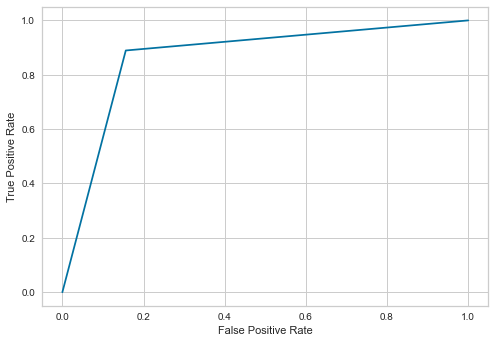

In [26]:

plot_roc_curve(target_test, target_pred)
print(f'model 2 AUC score: {roc_auc_score(target_test, target_pred)}') 

Para otras medidas de comparación revisar: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/